### Step 1
Activate the Plastid conda environment and open up a Jupyter Lab session (alternatively, a python file can be run in this python environment)

### Step 2
Load in all of the necessary Python packages.

In [1]:
# Load up the necessary packages 
import numpy as np
import pandas as pd
import dif_utils as dif
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
from multiprocess import Pool

In [2]:
# Define the path to our data files and the path we want to save our outputs in. 
data_path = "/home/keeganfl/Desktop/Work_Fall_2021/Protocol_test/genome/"
counts_path = "/home/keeganfl/Desktop/Work_Fall_2021/Protocol_test/position_counts/"
save_path = '/home/keeganfl/Desktop/Work_Fall_2021/Protocol_test/KS_stats/'
image_path = '/home/keeganfl/Desktop/Work_Fall_2021/Presentation_figures/'
mutation = 'Fmr1'
samp_num = '2'

### Step 3
Load in the count arrays for one sample of your mutant data and one sample of your control data. 

In [3]:
# Load in the count positions data.
data_mutant, names_mutant = dif.load_count_positions(counts_path + mutation+"_"+samp_num+"_counts.csv")
data_control, names_control = dif.load_count_positions(counts_path + "control_"+ samp_num +"_counts.csv")

### Step 4
filter out any count arrays that are of insufficient length or have insufficient read density. We filtered out count arrays which were under a hundred codons in length and which had a read density below 0.5 reads per codon, but the best filtering parameters will vary based on the quality of the data and the genome of the organism of study. Save the Gene ID's for the filtered count arrays into a list. 

In [4]:
# Find the correlation between all of the controls and the samples.
# Note that many of the lowest values spring from very short transcripts or transcripts with few reads. 
mutant_list = []
control_list = []
gene_list = []
for tr_m, tr_c, gene_name in zip(data_mutant, data_control, names_mutant):
    if len(tr_m) > 300 and sum(tr_m)/len(tr_m) > 0.2 and sum(tr_c)/len(tr_c) > 0.2:
        mutant_list.append(tr_m)
        control_list.append(tr_c)
        gene_list.append(gene_name)

### Step 5
Smooth out the count arrays using Loess smoothing and calculate the cumulative read distributions. the get_smoothed_vector() function from the keegan_analysis_tools python file is set up to perform Loess smoothing with a window size equal to 5% of the transcript length and calculates the cumulative read distribution. This step can take some time so it is recommended to use the multiprocess.Pool() function to complete this using multiple cores. 

In [5]:
max_pool = 20

# get smoothed vector arrays for all of the control data.
with Pool(max_pool) as p:
    pool_control, pool_mutant = list(
            p.imap(dif.get_smoothed_vector,
                   control_list)
        ), list(
            p.imap(dif.get_smoothed_vector,
                    mutant_list)
        )

In [6]:
len(mutant_list)

3175

### Step 6
For each gene in your mutant and control samples, calculate the KS-statistic as the maximum distance between their cumulative distributions and then save this KS-statistic as a list. 

In [7]:
ks_list = []
len_list = []
for tr_m, tr_c, index in zip(mutant_list, control_list, list(range(len(mutant_list)))):
    position = np.array(list(range(len(tr_m))))
    smoothed_vec_m, cumul_m = pool_mutant[index]
    smoothed_vec_c, cumul_c = pool_control[index]

    ks = max(abs(cumul_m - cumul_c))
    ks_list.append(ks)
    len_list.append(len(tr_m))

### Step 7
Combine the lists for the gene IDs, gene lengths, and KS statistics into a pandas dataframe using the pd.DataFrame, list() & zip() functions and save the resulting dataframe as a csv file using df.to_csv(). 

In [8]:
# reorganizing the lists into a dataframe. 
df_b = pd.DataFrame(list(zip(gene_list, ks_list, len_list)))
df_b.columns = ["gene_ID", "ks_stat", "gene_length"]
df_b.to_csv(save_path + "ks_table_" + samp_num + ".csv", index=False)

## (Optional) Choose a gene of interest and observe the smooth and unsmooth array.

In [9]:
# Choosing a gene of interest to calculate the elongation rates of. 
# Get the transcript and vector for the gene of interest.
my_gene = 'poe'
my_vec_mutant = None
my_vec_control = None
for tr_m, tr_c, name in zip(data_mutant, data_control, names_mutant):
    if name == my_gene:
        my_vec_mutant = tr_m
        my_vec_control = tr_c
if my_vec_mutant.any() == None:
    print("No gene found")

In [10]:
smoothed_vec_m, cumul_m = dif.get_smoothed_vector(my_vec_mutant+0.00000000001)
smoothed_vec_c, cumul_c = dif.get_smoothed_vector(my_vec_control+0.00000000001)

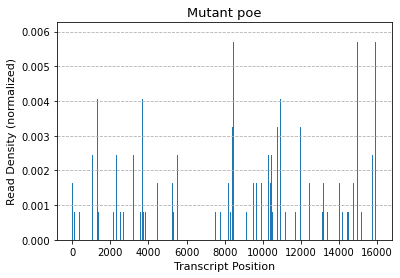

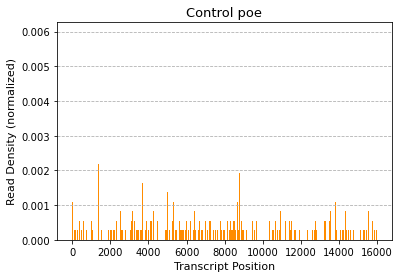

In [11]:
maxi = max([max(my_vec_mutant/sum(my_vec_mutant)), max(my_vec_control/sum(my_vec_control))])

plt.bar(list(range(len(my_vec_mutant))),my_vec_mutant/sum(my_vec_mutant), width = 4)
plt.ylim([0,maxi*1.1])
plt.ylabel("Read Density (normalized)", fontsize = 11)
plt.xlabel("Transcript Position", fontsize = 11)
plt.title("Mutant " + my_gene, fontsize = 13)
axes = plt.gca()
axes.yaxis.grid(linestyle = "--")
plt.savefig(image_path + my_gene + '_mutant_array.pdf')
plt.show()
plt.bar(list(range(len(my_vec_mutant))), my_vec_control/sum(my_vec_control), color = "darkorange", width = 4)
plt.ylim([0,maxi*1.1])
plt.ylabel("Read Density (normalized)", fontsize = 11)
plt.xlabel("Transcript Position", fontsize = 11)
plt.title("Control " + my_gene, fontsize = 13)
axes = plt.gca()
axes.yaxis.grid(linestyle = "--")
plt.savefig(image_path + my_gene + '_control_array.pdf')

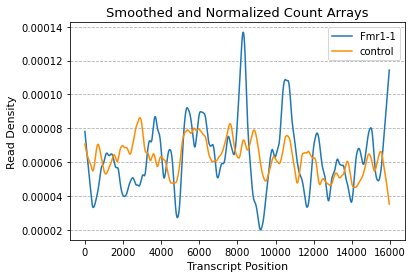

In [12]:
plt.plot(smoothed_vec_m, label = "Fmr1-1")
plt.plot(smoothed_vec_c, label = "control", color = "darkorange")
plt.ylabel("Read Density", fontsize = 11)
plt.xlabel("Transcript Position", fontsize = 11)
plt.title("Smoothed and Normalized Count Arrays", fontsize = 13)
plt.legend()
axes = plt.gca()
axes.yaxis.grid(linestyle = "--")
plt.savefig(image_path + my_gene +'_smoothed.pdf')

In [13]:
ks = max(abs(cumul_m - cumul_c))

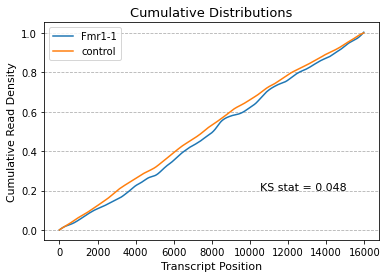

In [14]:
plt.plot(cumul_m, label = "Fmr1-1")
plt.plot(cumul_c, label = "control")
plt.text(len(cumul_c)*0.66, 0.2, "KS stat = " + str(round(ks,3)), fontsize = 11)
plt.ylabel("Cumulative Read Density", fontsize = 11)
plt.xlabel("Transcript Position", fontsize = 11)
plt.title("Cumulative Distributions", fontsize = 13)
plt.legend()
axes = plt.gca()
axes.yaxis.grid(linestyle = "--")
plt.savefig(image_path + my_gene + '_cumulative.pdf')